In [20]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.integrate import simps
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize

from collections import Counter
from itertools import product
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

import glob
import os

from datetime import datetime

A utility to get filenames time-date stamped

In [2]:
def get_unique_filename(fname):
    return fname.format(
        datetime.now().strftime("_%m-%d_%H-%M")
    )

# Loading and pre-processing pulses

Load pulses. Note that each pulse has its own time axis

In [3]:
folder_data = "experimental data 02-08-2022"

os.listdir(folder_data)

['export_N1_F07_x.txt',
 'export_N1_F05_x.txt',
 'export_N1_F08_x.txt',
 'export_N1_F06_x.txt',
 'export_N0_F05_x.txt',
 'export_N0_F06_x.txt',
 'export_N0_F07_x.txt',
 'export_N0_F08_x.txt']

## Loading "pure" harmonics

In [4]:
pulses = {}

# declare type
@dataclass
class Pulse:
    time: np.ndarray
    field: np.ndarray
    peaks_time: np.ndarray = None
    half_period: float = 0
    interp_field: InterpolatedUnivariateSpline = None
    
# save maximal amplitude of the field
max_ampl = []

for freq in range(5, 9):
    data = np.loadtxt(
        folder_data + '/export_N1_F0{}_x.txt'.format(freq)
    )
    time, field = data.T
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"
    
    label = '0.{} THz'.format(freq)
    
    abs_field = np.abs(field)

    max_ampl.append(abs_field.max())
    
    # Extract information for the combinatorial method     
    ampl_threshold = 0.4 * abs_field.max()
    
    indx = find_peaks(abs_field, height=ampl_threshold)[0]
    peaks_time = time[indx[1:-1]]
    
    half_period = Counter(np.diff(peaks_time)).most_common(1)[0][0]
    
    
    peaks_time = time[indx[1]:indx[-2]]
    
    # Saving the data 
    pulses[label] = Pulse(
        time = time, 
        field = field,
        peaks_time = peaks_time,
        half_period = half_period,
    )
    
# saving the largest frequency
largest_freq = label

#  Checking whether the time axis coincide
assert all(np.allclose(time, data.time) for data in pulses.values()), \
    "This workbook cannot be used since the time data is not syncronized"

# saving time step
dtime = time[1] - time[0]

max_ampl = max(max_ampl)

# Normalazing fields and interpolating
for data in pulses.values():
    data.field /= max_ampl
    
    data.interp_field = UnivariateSpline(
        data.time, 
        gaussian_filter1d(data.field, 1), 
        ext='zeros', 
        k=3, 
        s=0
    )


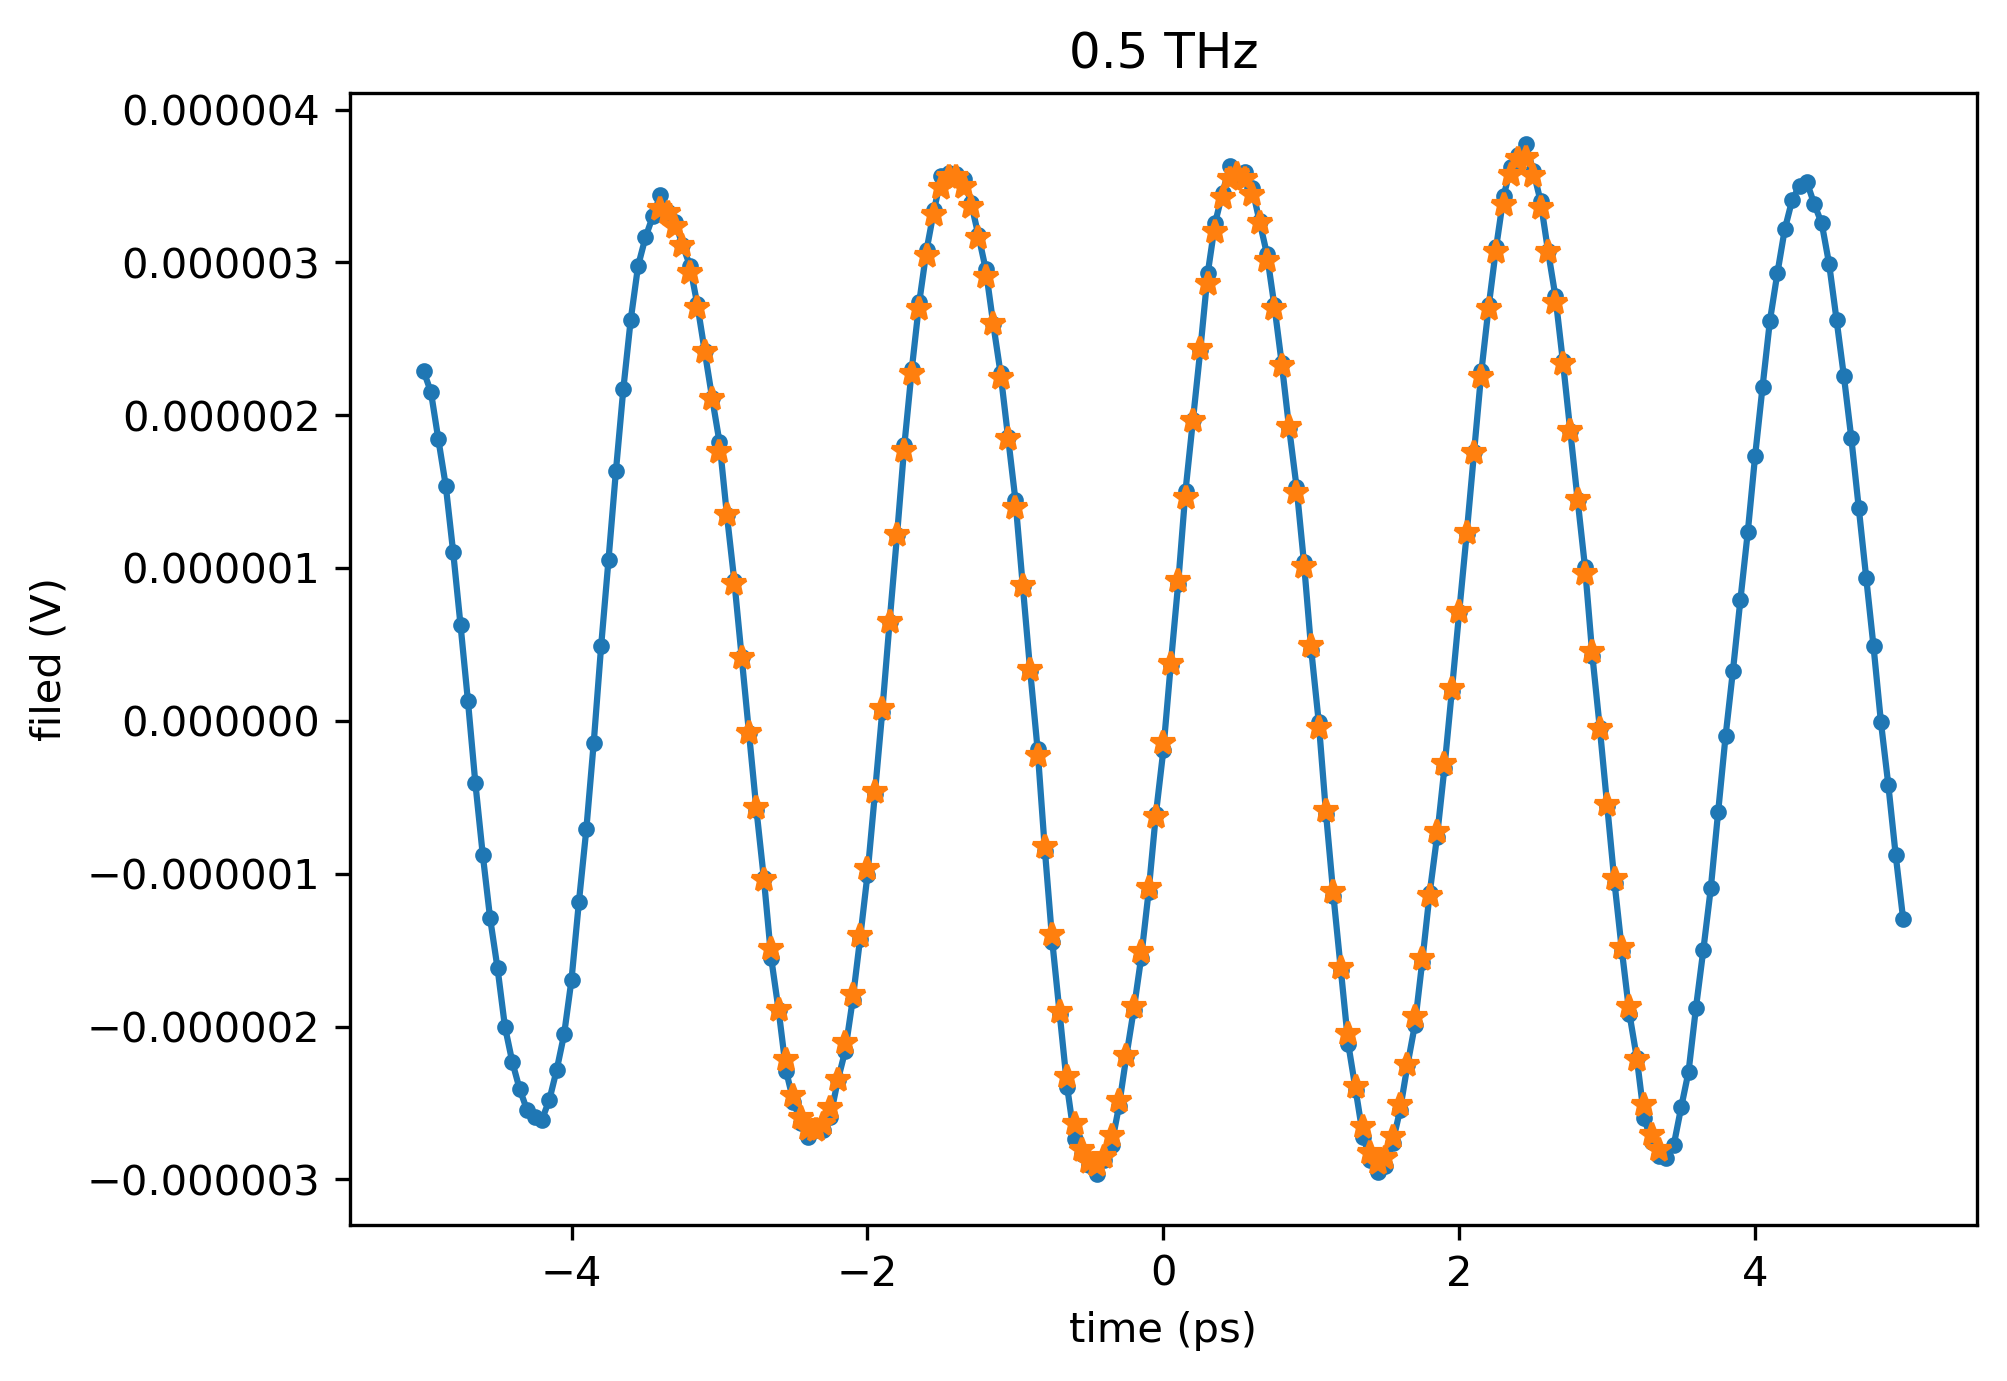

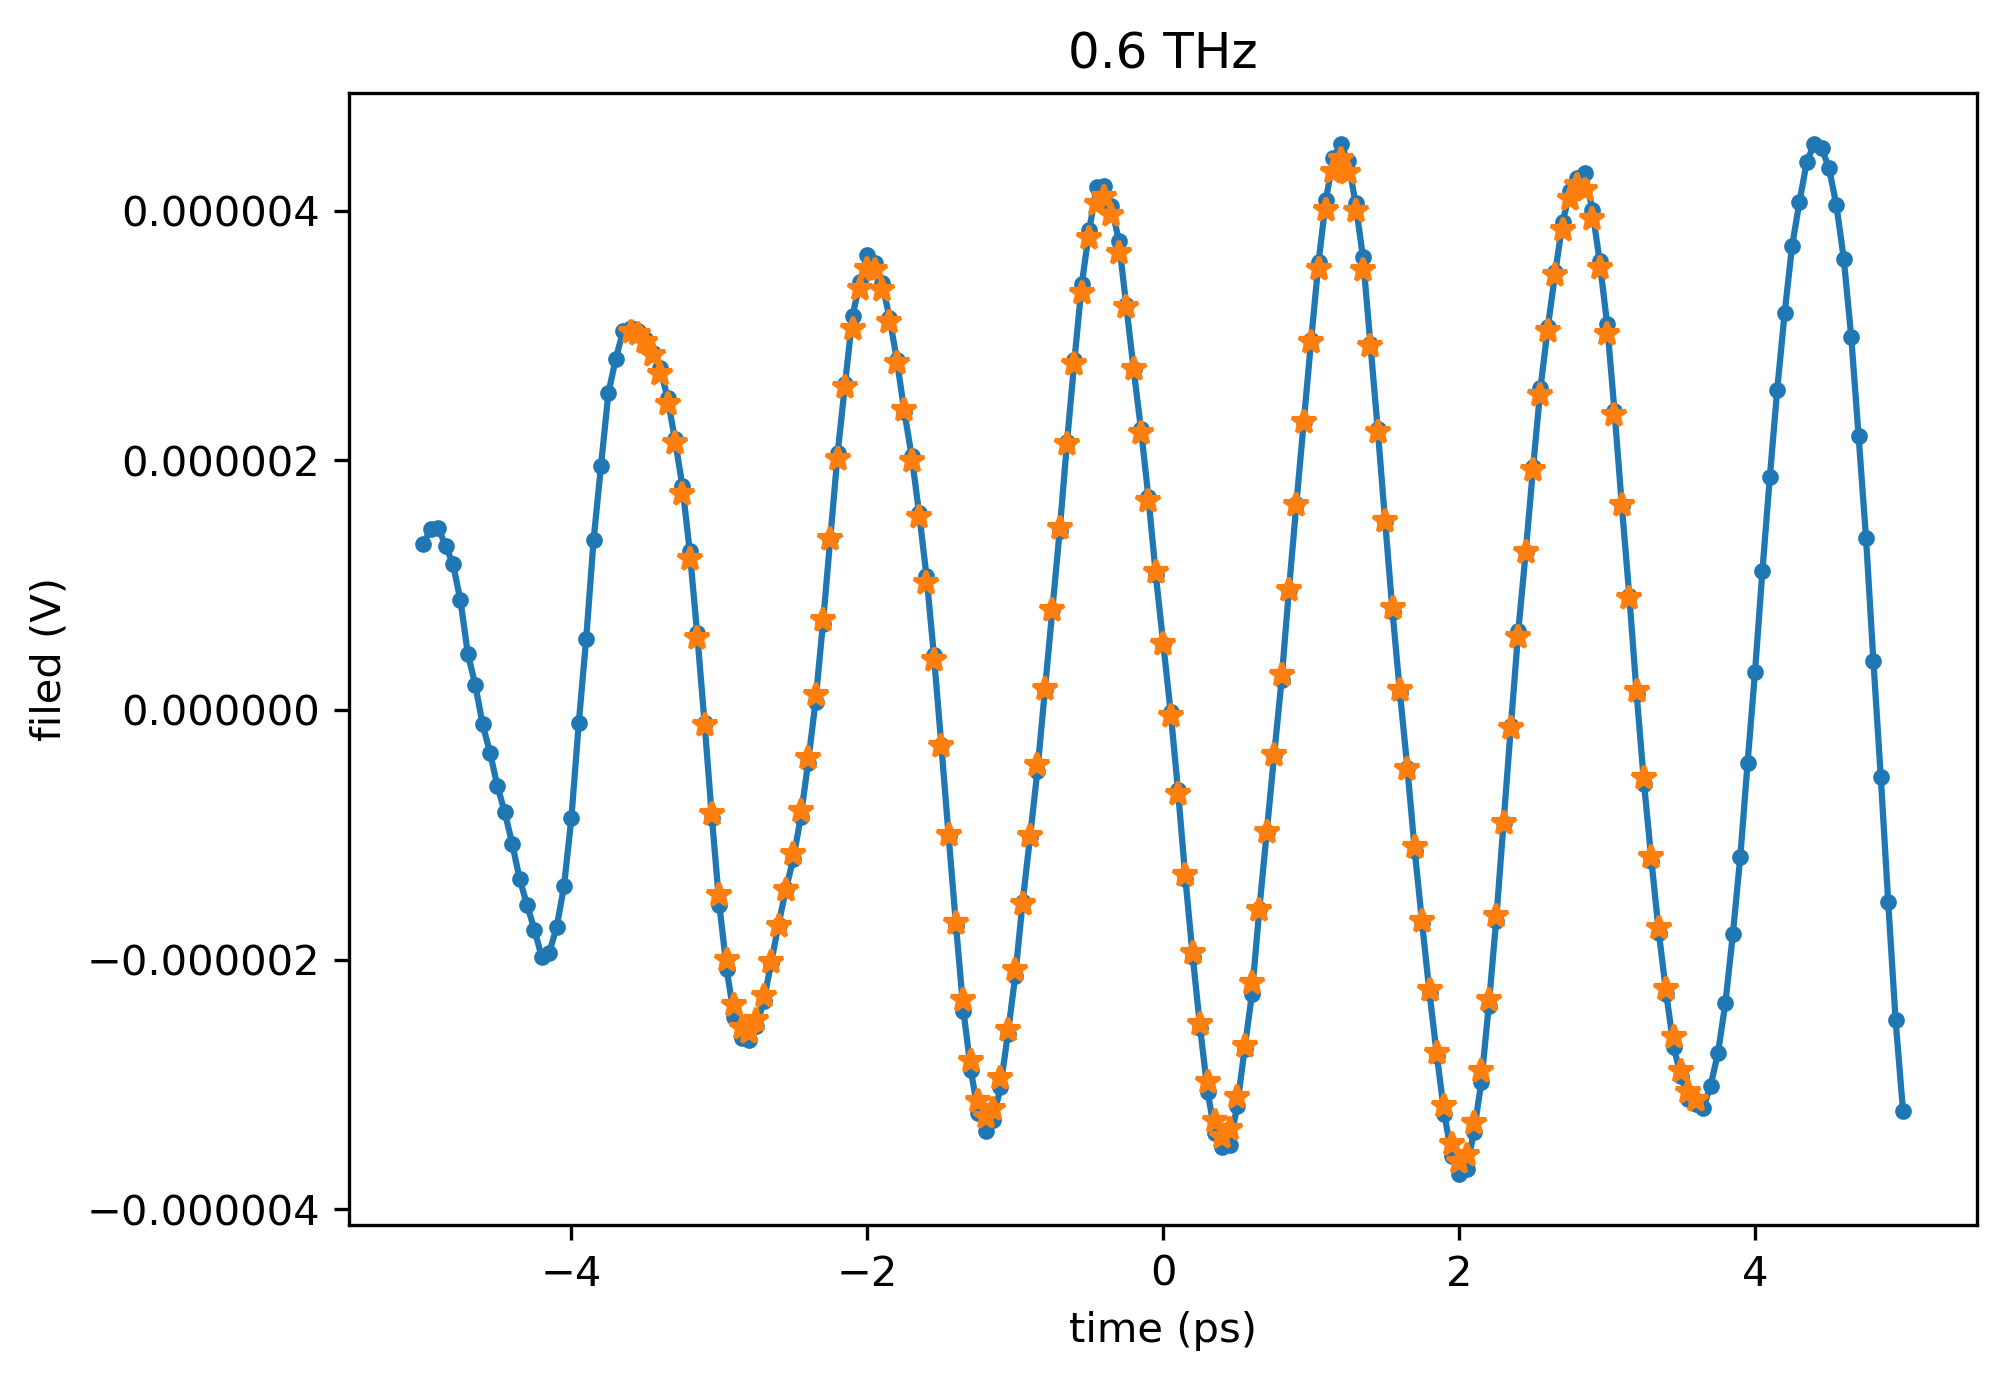

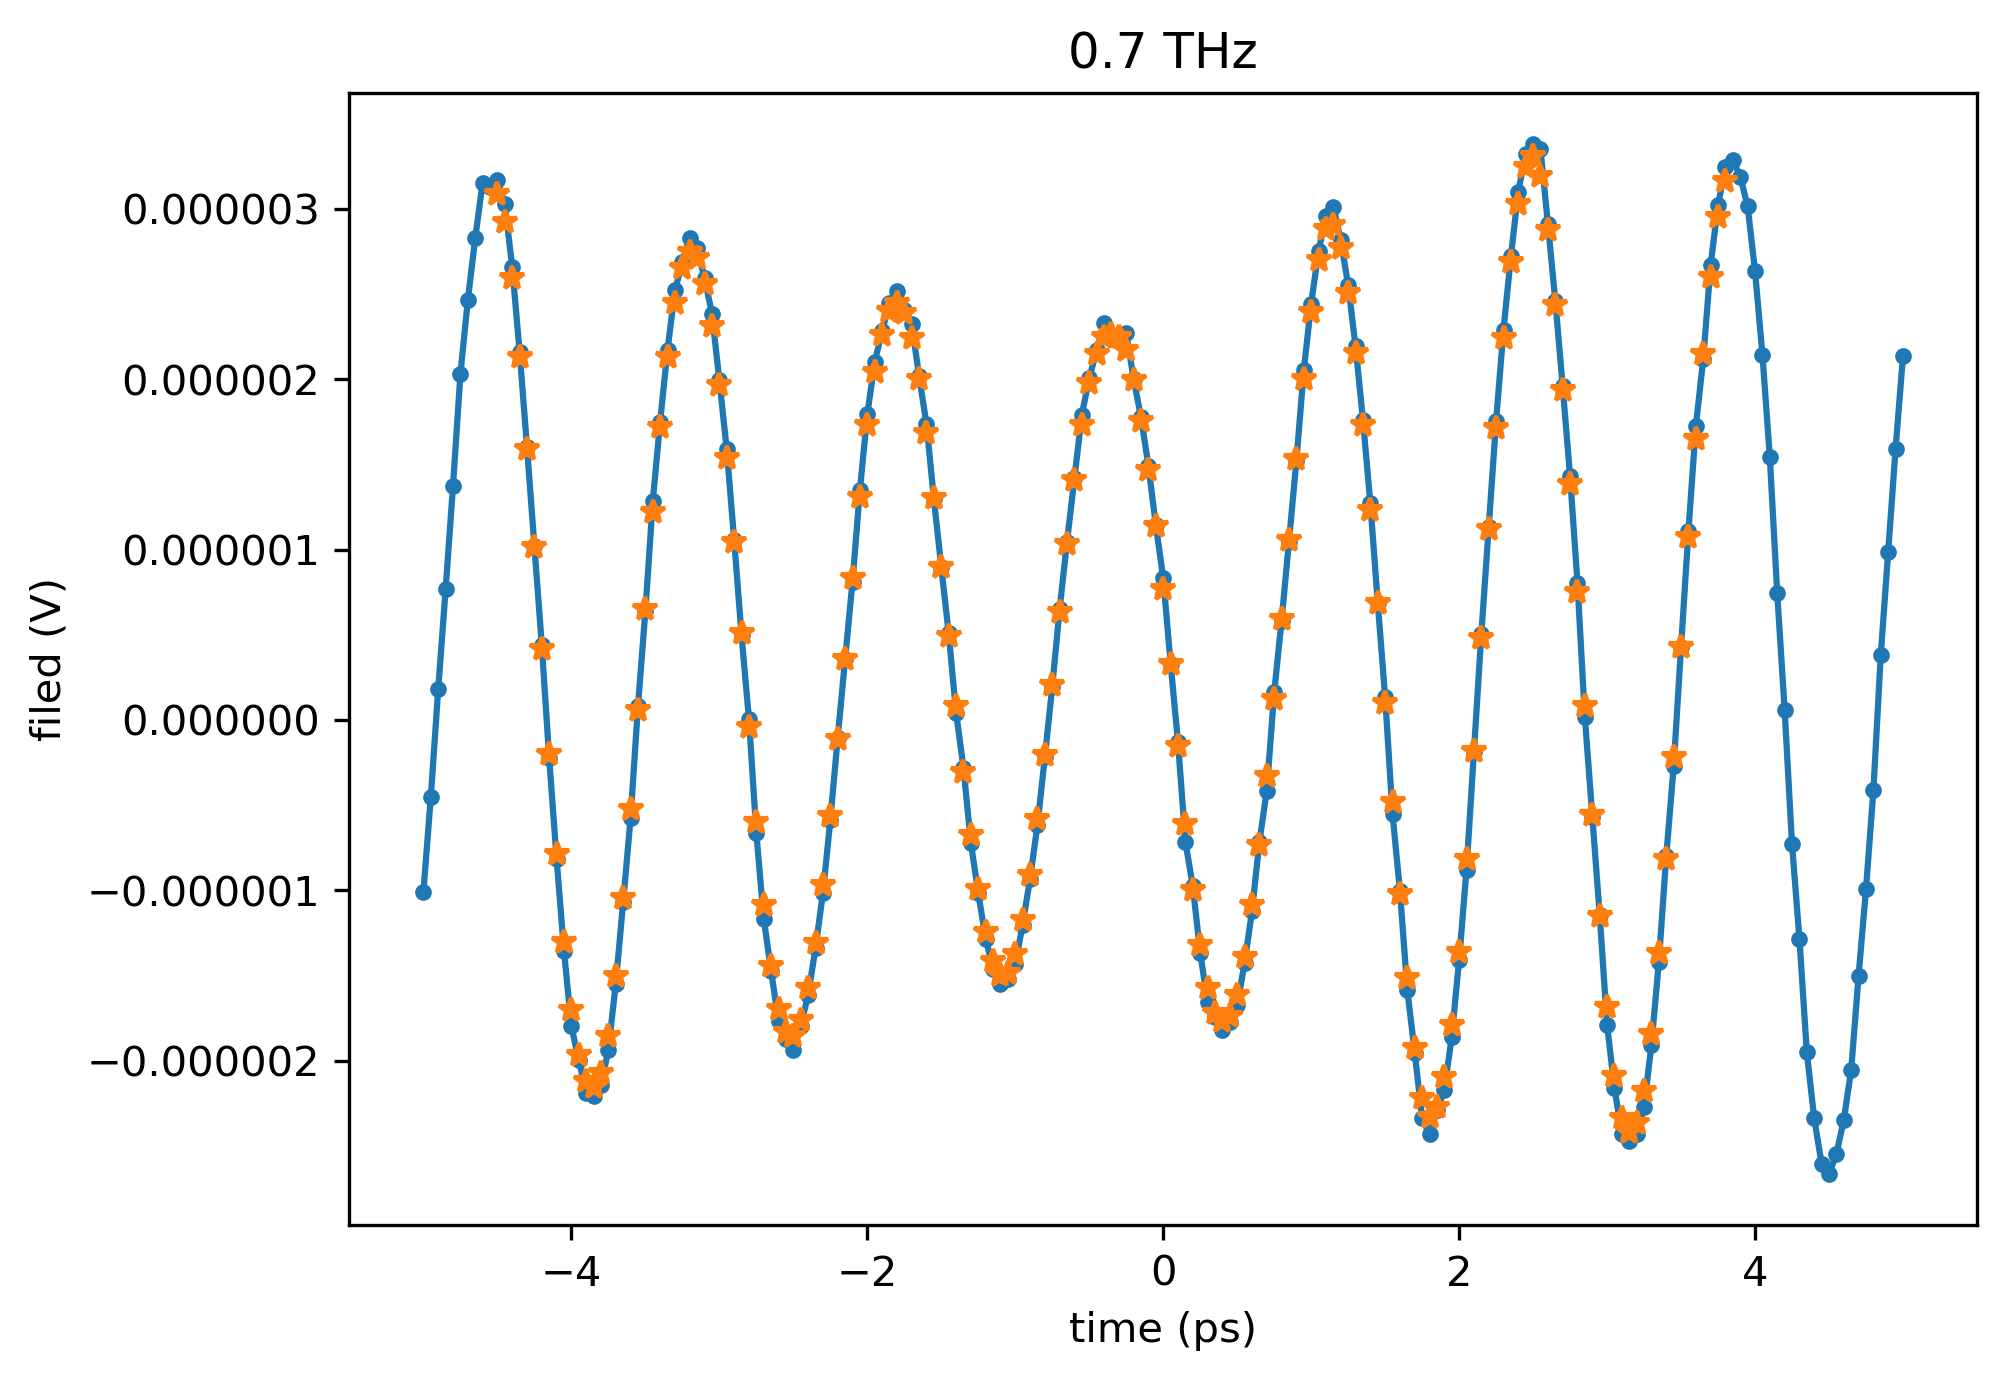

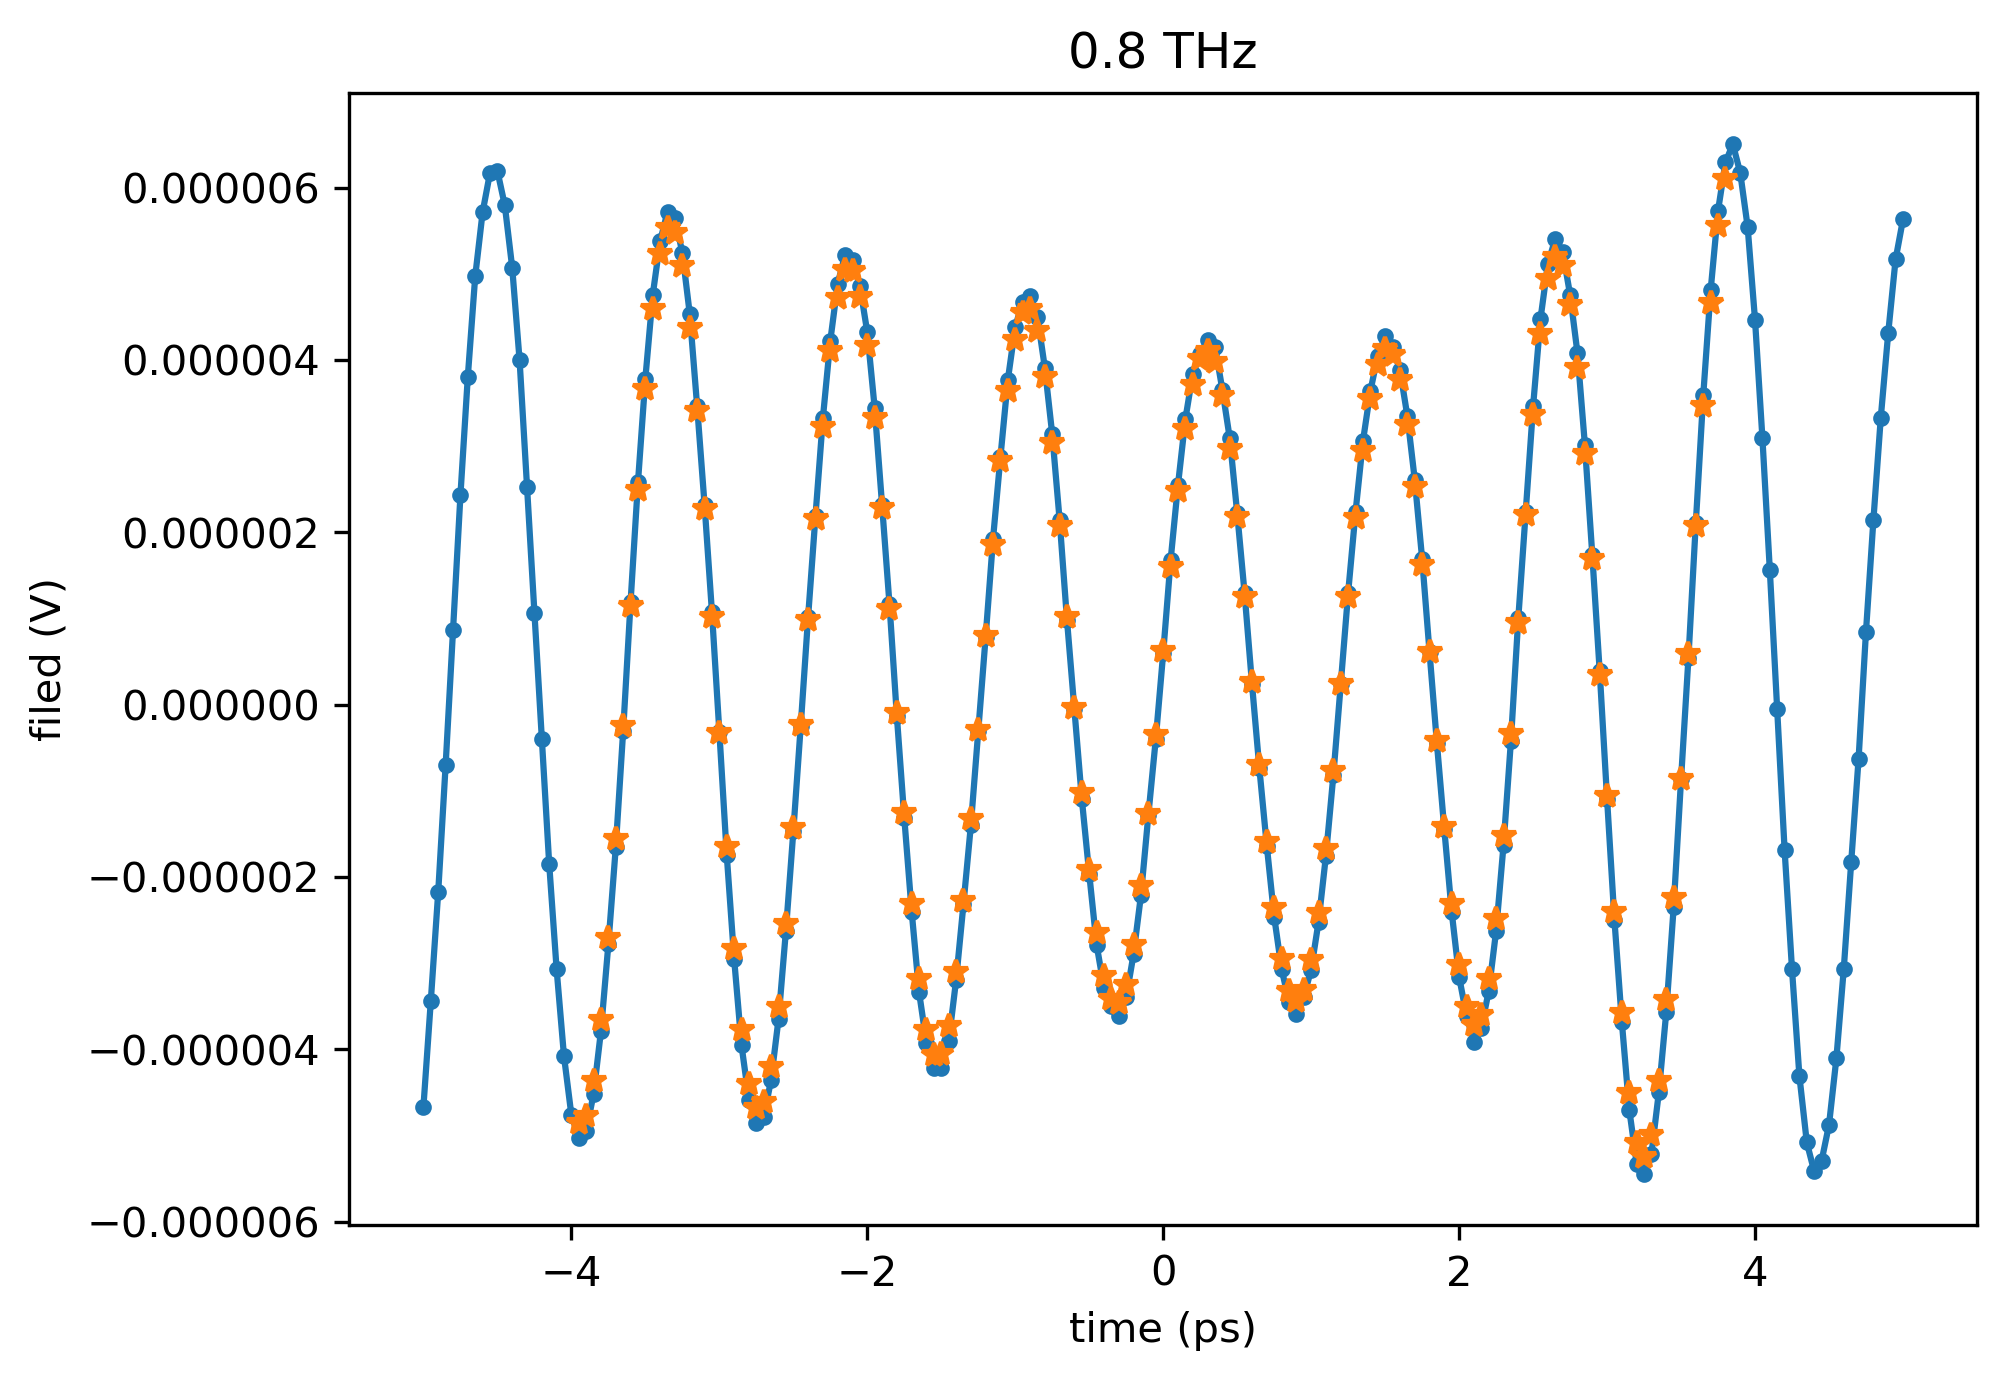

In [5]:
# Plot pulses
for freq, data in pulses.items():
    
    plt.figure(figsize=(7, 5), dpi=300)
    plt.title(freq)
    
    plt.plot(data.time, max_ampl * data.field, '.-')
    
    #t = np.linspace(time.min(), time.max(), 200)
    #plt.plot(t, data.interp_field(t))
    
    plt.plot(data.peaks_time, max_ampl * data.interp_field(data.peaks_time), '*')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    plt.show()  
    

## Load experimental superoscilations

In [22]:
def load_experimental_so(file_template):
    
    # load file names matching the pattern
    filenames = sorted(glob.glob(folder_data + file_template.format('*')))
    
    print(filenames)
    assert len(filenames) < 10, "Most likely the files are not ordered correctly"
    
    loaded_so = []

    for _ in filenames:
        data = np.loadtxt(_)
        time, field = data.T

        # check that time is time
        assert np.all(np.diff(time) > 0), "`time` is probably not time"

        loaded_so.append(
            Pulse(
                time = time, 
                field = field / max_ampl,
            )
        )
        
    return loaded_so

long_experimental_so = load_experimental_so('/export_theory{}_new_long_x.txt')
short_experimental_so = load_experimental_so('/export_theory{}_new_short_x.txt')

assert len(long_experimental_so) == len(short_experimental_so)

['experimental data 02-08-2022/export_theory0_new_long_x.txt', 'experimental data 02-08-2022/export_theory1_new_long_x.txt', 'experimental data 02-08-2022/export_theory2_new_long_x.txt']
['experimental data 02-08-2022/export_theory0_new_short_x.txt', 'experimental data 02-08-2022/export_theory1_new_short_x.txt', 'experimental data 02-08-2022/export_theory2_new_short_x.txt']


### Plotting short and long measurement at the same time  

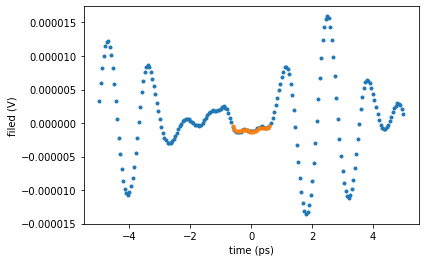

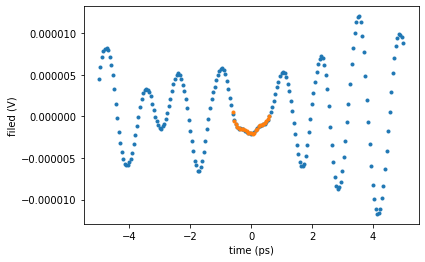

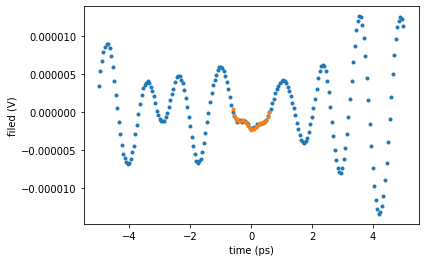

In [23]:
for long, short in zip(long_experimental_so, short_experimental_so):
    plt.plot(long.time, max_ampl * long.field, '.')
    plt.plot(short.time, max_ampl * short.field, '.')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    plt.show()

### Manually extract observational time window 

0.6000000000000001


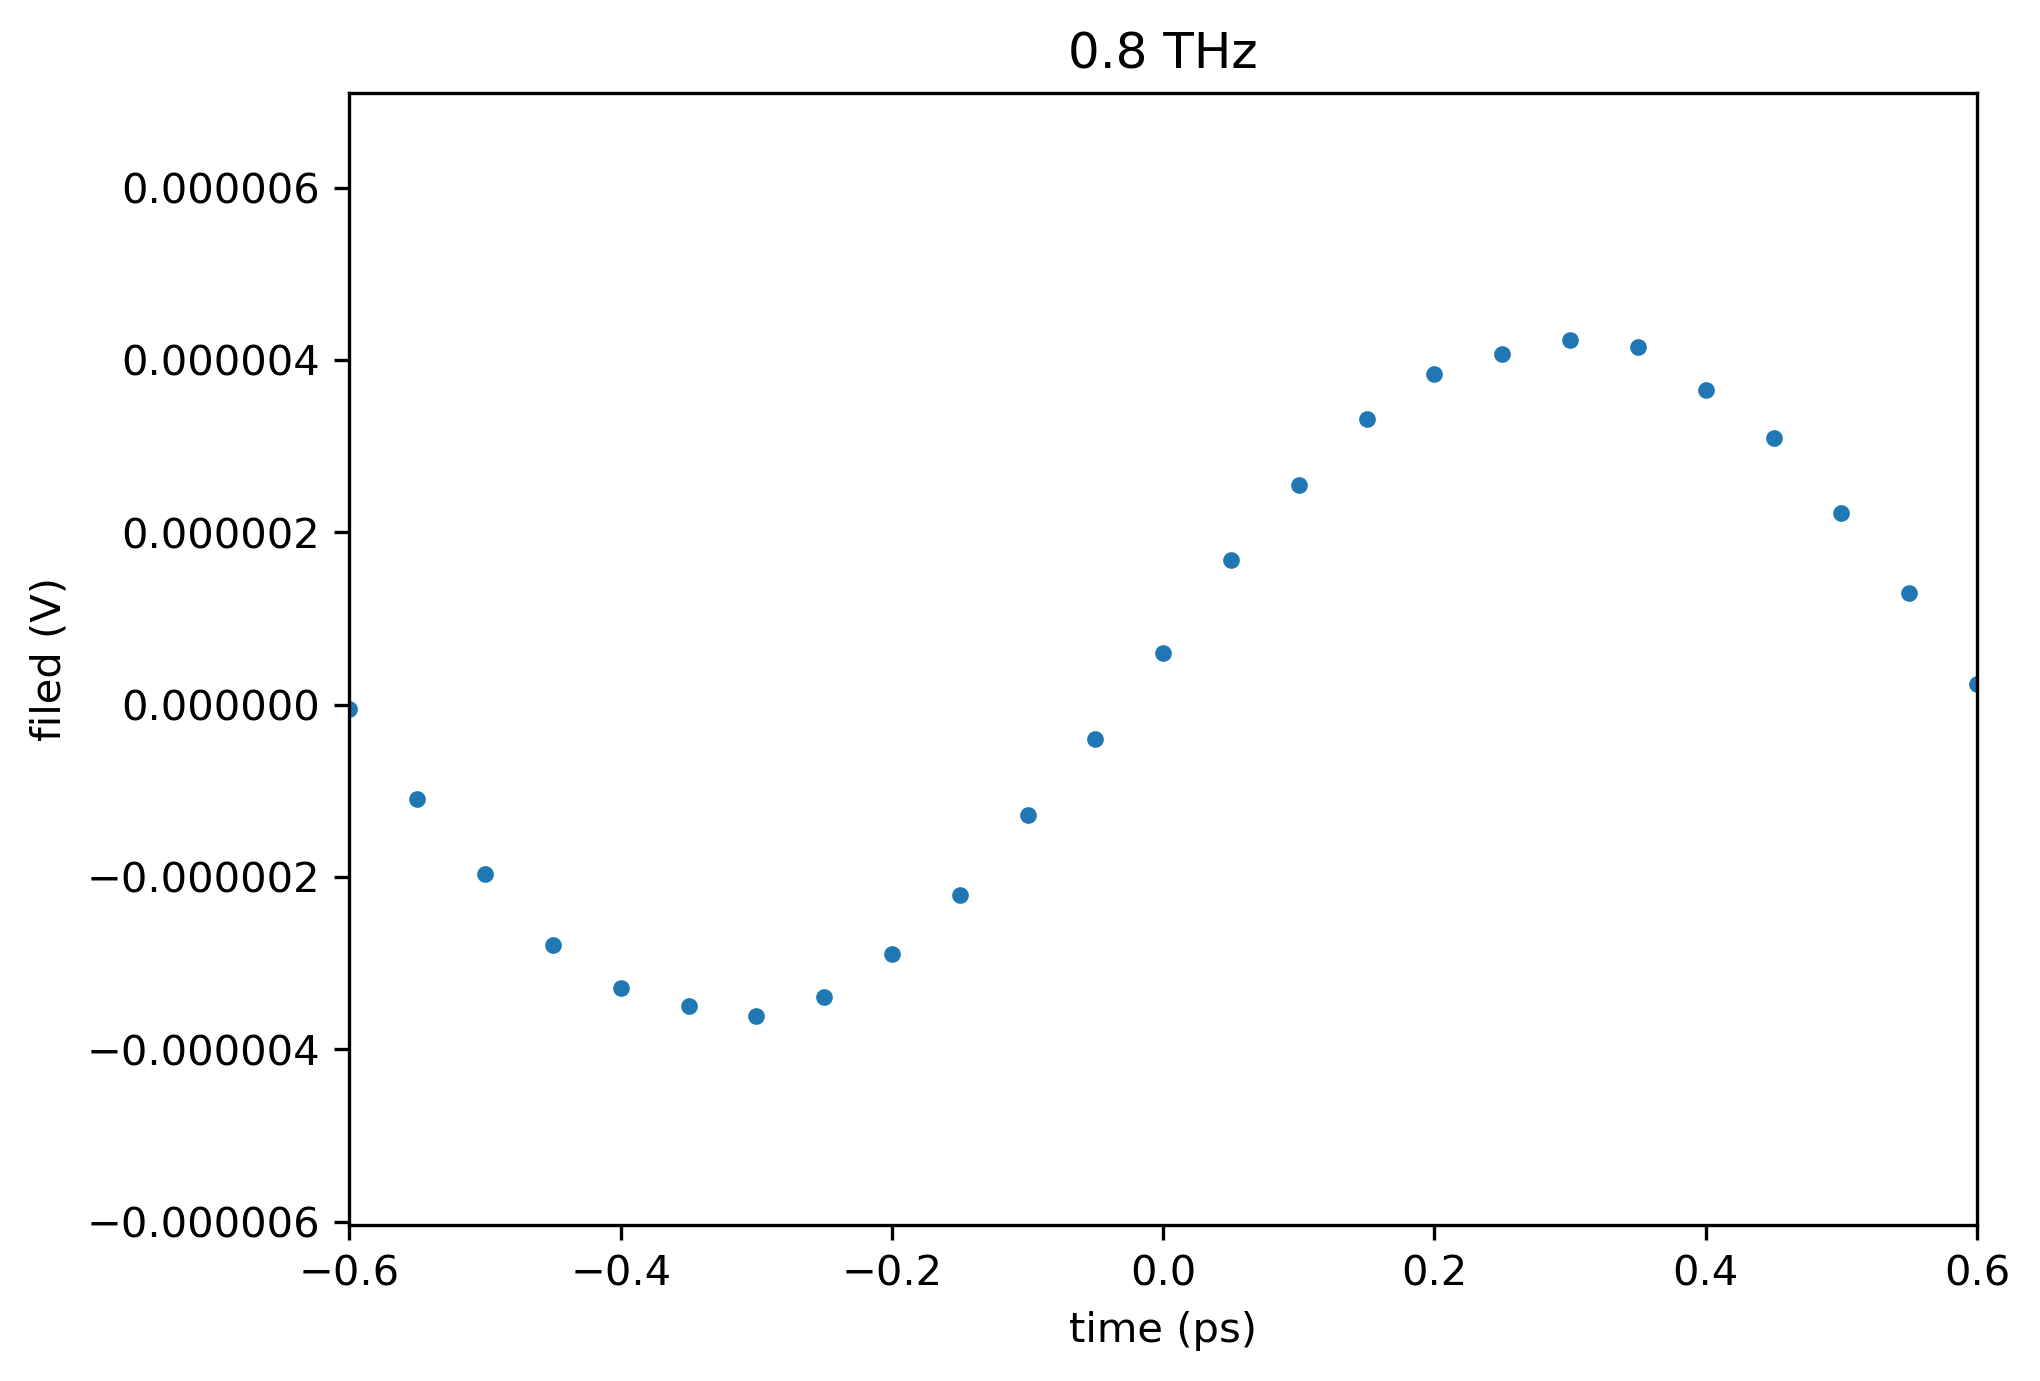

In [6]:
plt.figure(figsize=(7, 5), dpi=300)
    
field = pulses[largest_freq].field
half_period = pulses[largest_freq].half_period

print(half_period)

plt.plot(time, max_ampl * field, '.')

#indx = maxima_position[largest_freq]
indx = 200

observational_window = -half_period, half_period
#observational_window = time[indx - 14], time[indx + 12]

plt.xlim(observational_window)
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.title(largest_freq)    
plt.show()

### Plot all pulses within the observational window

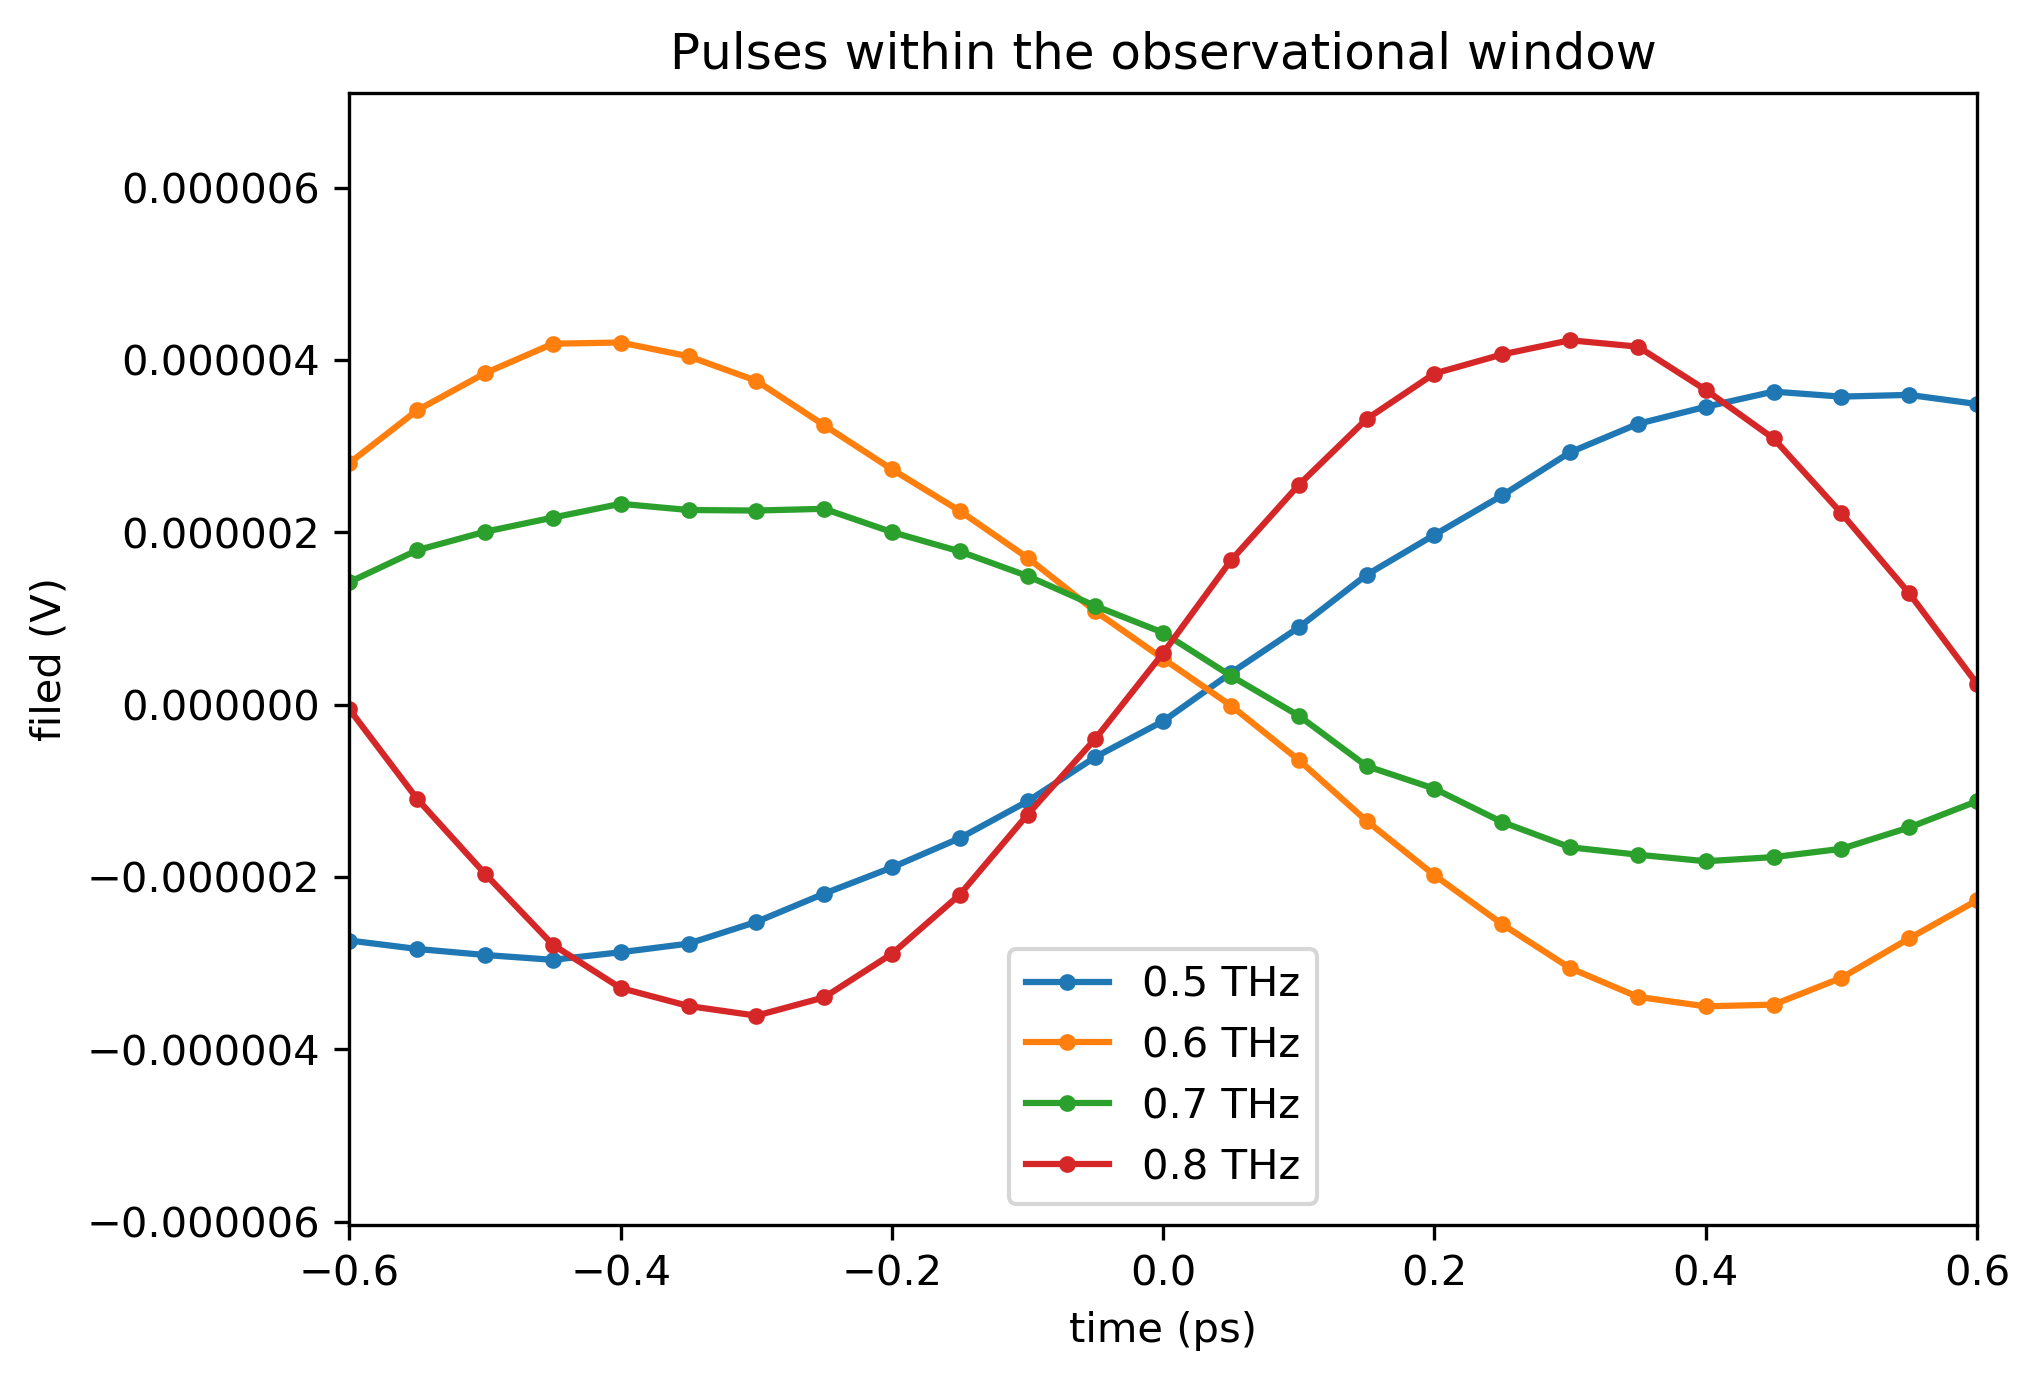

In [7]:
# Plot pulses
plt.figure(figsize=(7, 5), dpi=300)

plt.title("Pulses within the observational window")

for freq, data in pulses.items():
    plt.plot(data.time, max_ampl * data.field, '.-', label=freq)
    

#plt.plot(combined_pulse.time, combined_pulse.field, '.-', color='black', label='experimental pulse')
    
plt.xlim(np.array(observational_window))
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')    

plt.legend()
plt.show()  

# Synthesizing superoscillations 


# New combinatorial method

Define all time possible time delays  

In [8]:
all_time_delays = list(product(*[_.peaks_time for _ in pulses.values()]))
len(all_time_delays)

513745440

Time window for constructing superoscilations

In [28]:
half_period = pulses[largest_freq].half_period
time_window, dx = np.linspace(-half_period, half_period, 100, retstep=True)

time_window_raw = time[(time >= -half_period) & (time <= half_period)] 

## Get superoscilationsby using time delays only 

In [29]:
def get_combined_field(time_delays, time_window):
    return sum(
        _.interp_field(time_window - delay) for delay, _ in zip(time_delays, pulses.values())
    )

def inegral_without_ampl_modulation(time_delays):
    
    return simps(get_combined_field(time_delays, time_window) ** 2, dx=dx)

def jac_inegral_without_ampl_modulation(time_delays):
        
    E = get_combined_field(time_delays, time_window)
    
    return np.array([     
        -2. * simps(E * _.interp_field.derivative()(time_window - delay), dx=dx) 
        for delay, _ in zip(time_delays, pulses.values())
    ])

In [11]:
with Pool(cpu_count()) as pool:
    intensity_without_ampl_modulation = pool.map(inegral_without_ampl_modulation, tqdm(all_time_delays))

 453852774/453852774 [34:55<00:00, 216554.52it/s]

Extract the best candidates for getting superoscilations  

In [12]:
intensity_without_ampl_modulation = np.array(intensity_without_ampl_modulation)
indx = np.argsort(intensity_without_ampl_modulation)
intensity_without_ampl_modulation = intensity_without_ampl_modulation[indx]

all_time_delays = np.array(all_time_delays)[indx]

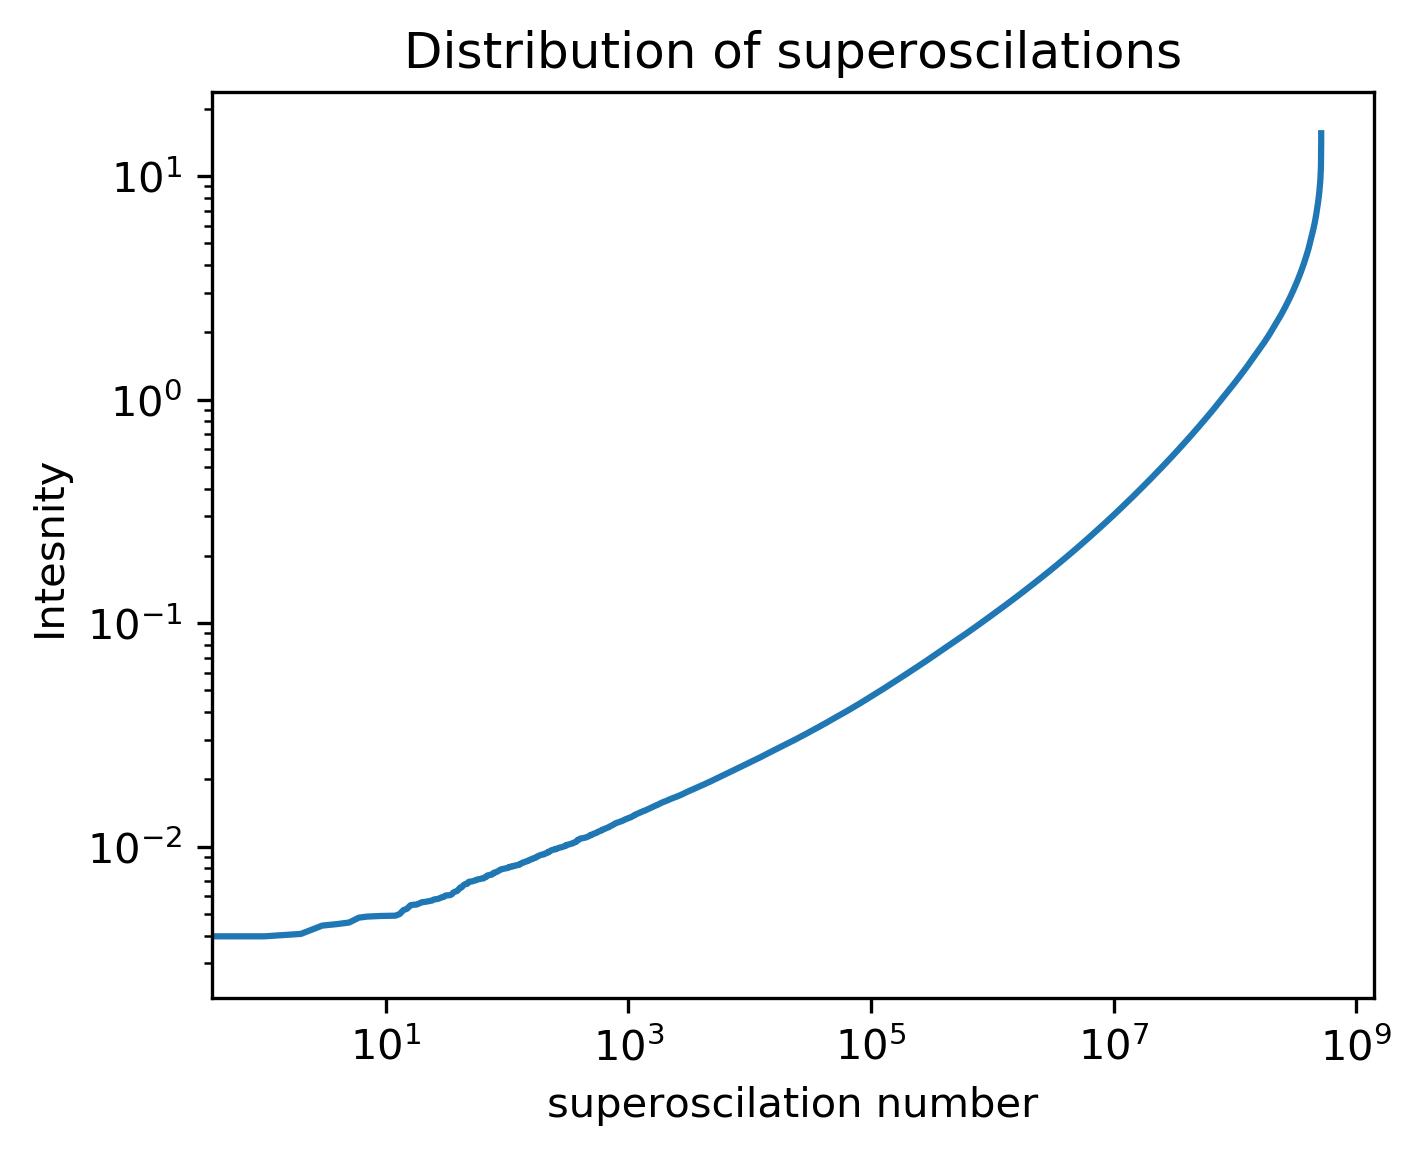

In [13]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_without_ampl_modulation)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

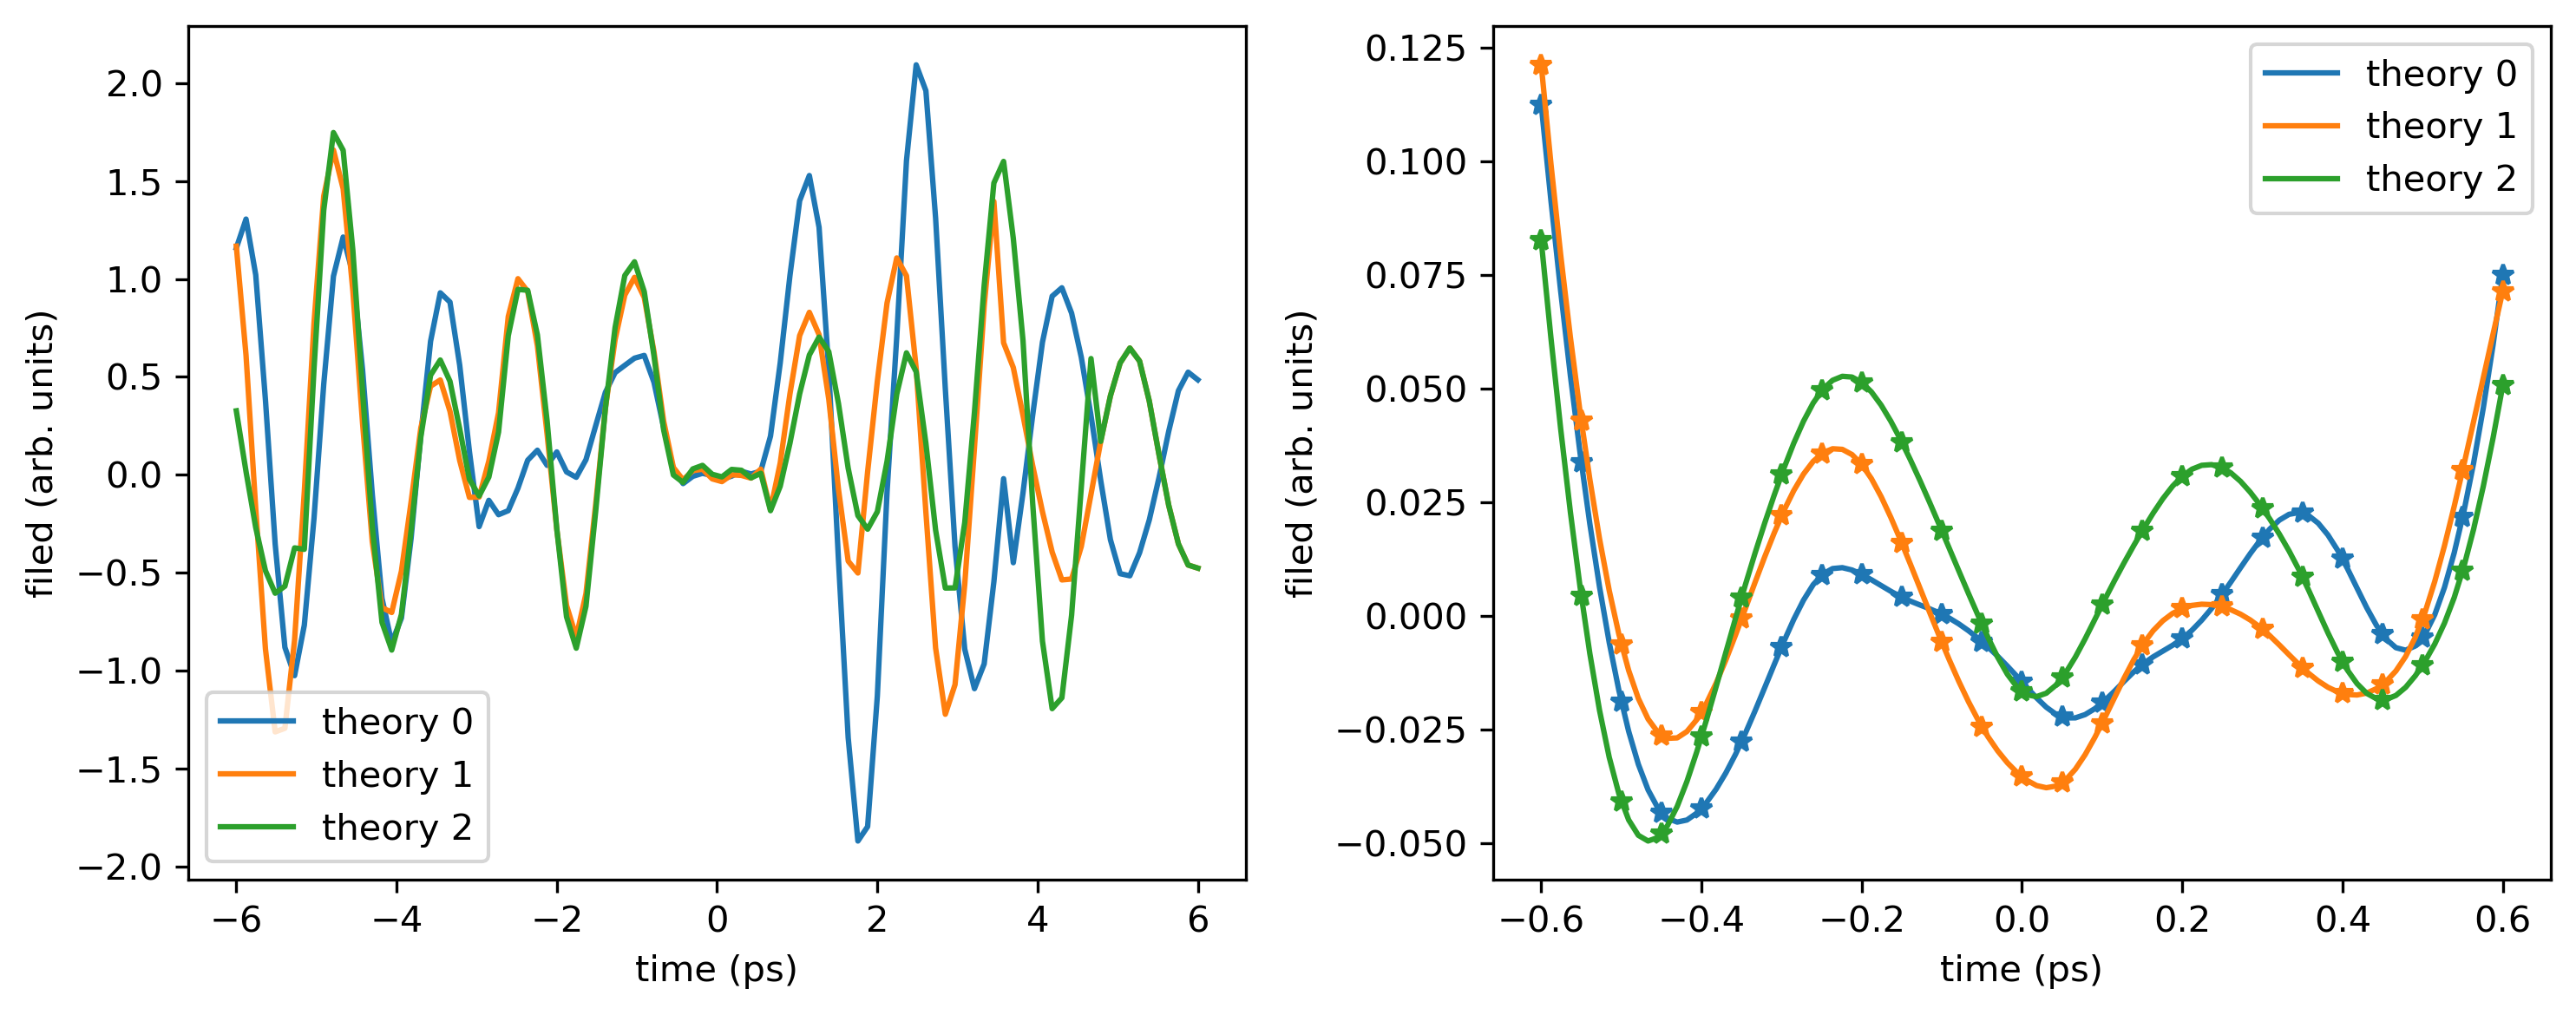

In [30]:
plt.figure(figsize=(10,4), dpi=300)
plt.title("Best superoscilations")

plt.subplot(121)

long_time_window = 10 * time_window

for n, time_delays in enumerate(all_time_delays[:3]):
    plt.plot(long_time_window, get_combined_field(time_delays, long_time_window), label="theory {}".format(n))
    
#for n, long in enumerate(long_experimental_so[:3]):
#    plt.plot(long.time, long.field, '.', label="experiment {}".format(n))
    
    
plt.xlabel('time (ps)')
plt.ylabel('filed (arb. units)')
plt.legend()

plt.subplot(122)

for n, time_delays in enumerate(all_time_delays[:3]):
    line = plt.plot(time_window, get_combined_field(time_delays, time_window), label="theory {}".format(n))
    line = line[0]
    
    # display raw points
    plt.plot(time_window_raw, get_combined_field(time_delays, time_window_raw), '*', color = line.get_color())

#for n, short in enumerate(short_experimental_so[:3]):
#    plt.plot(short.time, short.field, '.', label="experiment {}".format(n))
    

plt.xlabel('time (ps)')
plt.ylabel('filed (arb. units)')
plt.legend()

plt.tight_layout()
plt.savefig(get_unique_filename("predicted_so_{}.png"))

plt.show()  

In [31]:
np.all(
    all_time_delays[:10] == np.array([[ 2.1 ,  2.95, -2.8 , -1.35],
       [-3.2 ,  2.35, -4.4 , -1.5 ],
       [-1.3 ,  2.35, -4.35, -0.25],
       [-1.3 ,  2.35, -3.05, -1.5 ],
       [ 2.1 ,  2.95, -4.15, -1.35],
       [ 2.05,  2.95,  1.3 , -1.45],
       [ 2.05, -3.25, -0.4 , -1.45],
       [-1.35,  2.3 , -4.4 , -0.3 ],
       [ 2.05,  2.9 , -2.85, -1.4 ],
       [ 0.6 ,  2.35, -4.35, -0.25]])
)

True

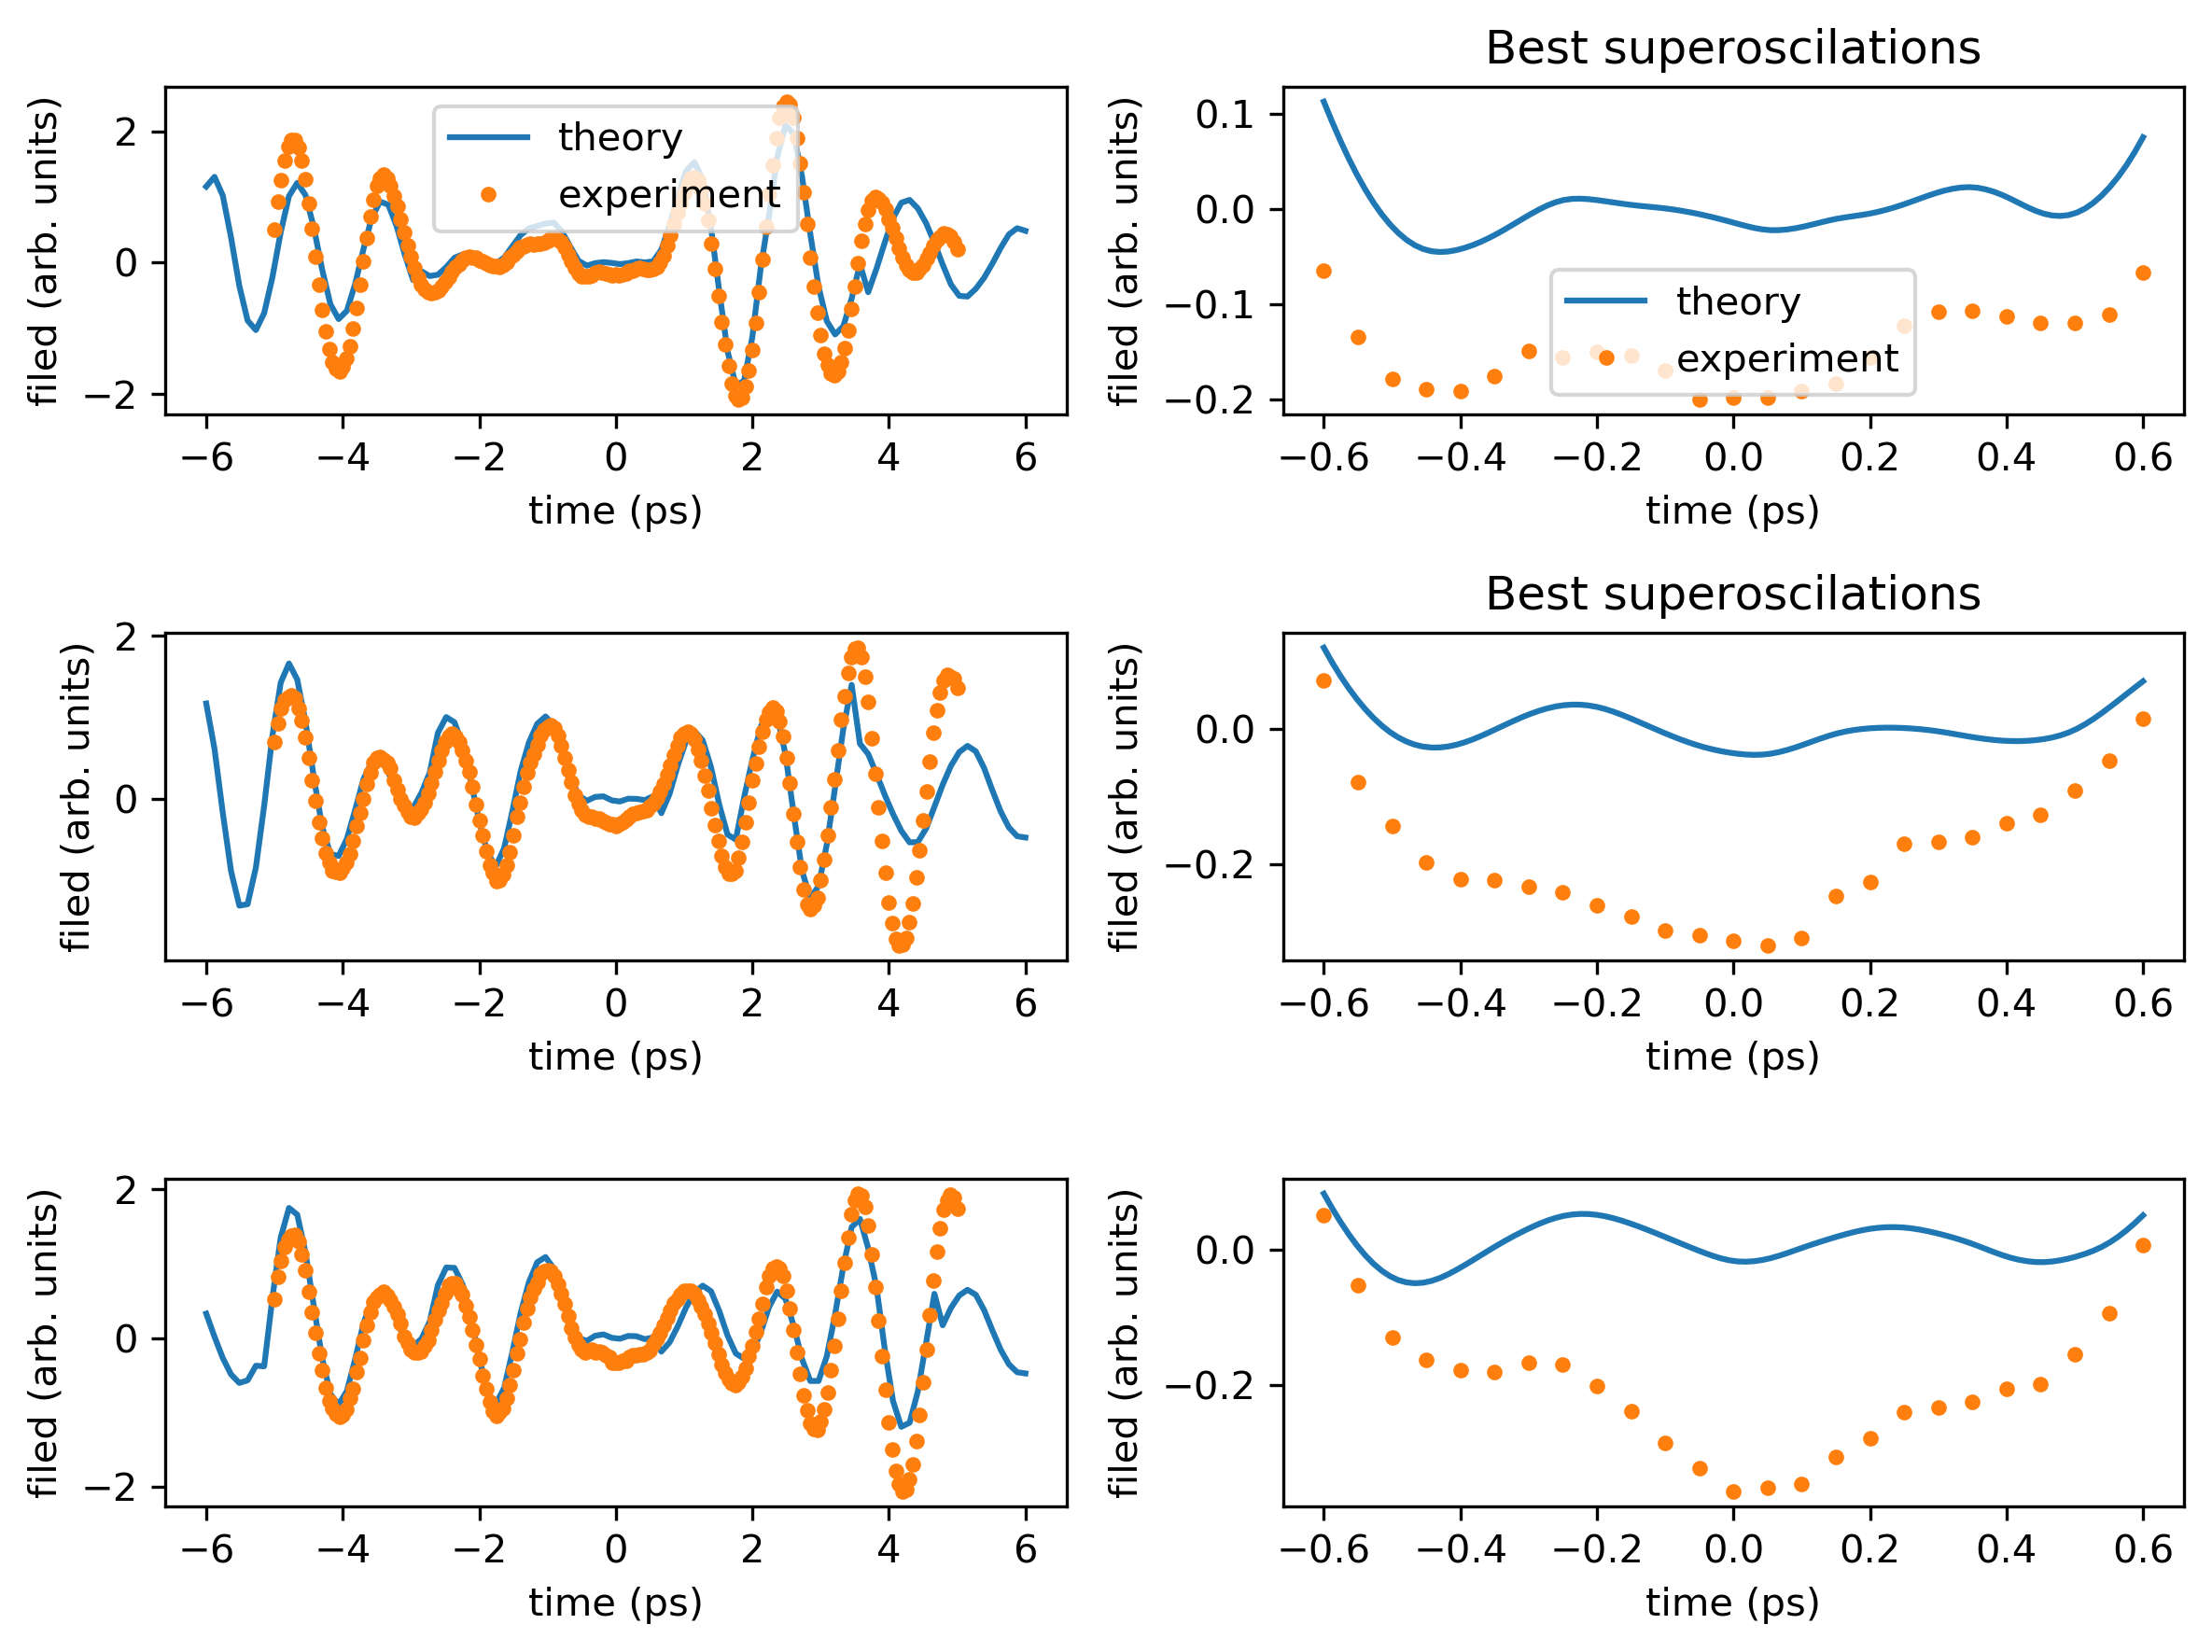

In [32]:
long_time_window = 10 * time_window

data_plotting = list(zip(all_time_delays, long_experimental_so, short_experimental_so))
n_plots = len(data_plotting)

plt.figure(figsize=(8, 2 * n_plots), dpi=300)

for n, (time_delays, long, short,) in enumerate(data_plotting):

    
    plt.title("Best superoscilations")

    plt.subplot(n_plots, 2, 2 * n + 1)

    plt.plot(
        long_time_window, get_combined_field(time_delays, long_time_window), 
        label=(None if n else "theory")
    )

    plt.plot(long.time, long.field, '.', label=(None if n else "experiment"))
    if n == 0:
        plt.legend()

    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. units)')

    plt.subplot(n_plots, 2, 2 * n + 2)

    plt.plot(
        time_window, 
        get_combined_field(time_delays, time_window), 
        label=(None if n else "theory")
    )
    
    plt.plot(short.time, short.field, '.', label=(None if n else "experiment"))
    if n == 0:
        plt.legend()
        
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. units)')
    


plt.tight_layout()
plt.savefig(get_unique_filename("predicted_so_{}.png"))
plt.show()  

In [25]:
all_time_delays[:10]

array([[ 2.1 ,  2.95, -2.8 , -1.35],
       [-3.2 ,  2.35, -4.4 , -1.5 ],
       [-1.3 ,  2.35, -4.35, -0.25],
       [-1.3 ,  2.35, -3.05, -1.5 ],
       [ 2.1 ,  2.95, -4.15, -1.35],
       [ 2.05,  2.95,  1.3 , -1.45],
       [ 2.05, -3.25, -0.4 , -1.45],
       [-1.35,  2.3 , -4.4 , -0.3 ],
       [ 2.05,  2.9 , -2.85, -1.4 ],
       [ 0.6 ,  2.35, -4.35, -0.25]])